In [1]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch

def download_mnist(is_train: bool):
    dataset = MNIST(root='./data',
                    transform= lambda x: np.array(x).flatten(),
                    download=True,
                    train=is_train)
    mnist_data= []
    mnist_labels= []
    for image, label in dataset:
        mnist_data.append(image)
        mnist_labels.append(label)

    return mnist_data, mnist_labels

def process_data(mnist_data, mnist_labels):
    mnist_data = np.array(mnist_data).reshape(-1, 784)
    mnist_labels = np.array(mnist_labels).reshape(-1, 1)

    procesed_mnist_labels = []
    for mnist_label in mnist_labels:
        a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        value = mnist_label[0]
        a[value] = 1
        procesed_mnist_labels.append(np.array(a))

    mnist_data = mnist_data / 255
    return mnist_data, procesed_mnist_labels

In [2]:
# 2. Split data into batches
from torch.utils.data import TensorDataset

def split_in_batches(data, labels, batch_size=100):
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    batched_data = []
    batched_labels = []

    for batch_data, batch_labels in loader:
        batched_data.append(batch_data.numpy())
        batched_labels.append(batch_labels.numpy())
    return batched_data, batched_labels 

In [4]:
class Perceptron:
    def __init__(self, input_size, num_classes):
        self.weights = np.random.randn(input_size, num_classes) * 0.01
        self.bias = np.zeros((1, num_classes))
    
    # Here we compute the softmax function 
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True) # normalization 
    
    # Here we compute the forward pass 
    def forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z) # we return the probabilities of each class
    
    # Here we compute the loss
    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0] 
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-9)) / m # cross-entropy loss ,we compute mean loss
        return loss

    # Here we actually compute the gradients and update the weights and biases
    def backward(self, X, Y_pred, Y_true, learning_rate):
        m = X.shape[0] # number of examples
        dz = Y_pred - Y_true  # error term
        dw = np.dot(X.T, dz) / m  # gradient for weights
        db = np.sum(dz, axis=0, keepdims=True) / m  # gradient for biases
        # aici e acelasi lucru cu weights += learning_rate * dw daca dz = Y_true - Y_pred.
        # practic aplicam gradient descent : x = x - df/dx ,(derivata lui f in functie de x)
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db

In [25]:
# 4. Forward pass (logits computation)
def train_epoch(process_train_X, process_train_Y, perceptron, learning_rate):
    batched_train_data, batched_train_labels = split_in_batches(process_train_X, process_train_Y)

    epoch_loss = 0

    for batch_data, batch_labels in zip(batched_train_data, batched_train_labels):
        probabilities = perceptron.forward(batch_data)
        loss = perceptron.compute_loss(probabilities, batch_labels)
        perceptron.backward(batch_data, probabilities, batch_labels, learning_rate)
        epoch_loss += loss

    epoch_loss /= len(batched_train_data)
    print(f"Epoch loss: {epoch_loss}")

    return epoch_loss


In [24]:
def calculate_accuracy(data, labels, perceptron):
    probabilities = perceptron.forward(data)
    predicted_classes = np.argmax(probabilities, axis=1) # get the index of the highest probability
    true_classes = np.argmax(labels, axis=1)   # get the index of the true class
    correct_predictions = np.sum(predicted_classes == true_classes) # count how many predictions were correct
    accuracy = correct_predictions / len(labels) * 100 
    return accuracy

In [26]:
train_X, train_Y = download_mnist(True)
test_x, test_y = download_mnist(False)

process_train_X, process_train_Y = process_data(train_X, train_Y)
process_test_x, process_test_y = process_data(test_x, test_y)

# just first time
input_size = 28 * 28
num_classes = 10
learning_rate = 0.1
perceptron = Perceptron(input_size, num_classes)

## here we train the model
num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = train_epoch(process_train_X, process_train_Y, perceptron, learning_rate)
    print(f"Loss after epoch {epoch + 1}: {epoch_loss}")

# Calculate the accuracy on the training data
train_accuracy = calculate_accuracy(process_train_X, process_train_Y, perceptron)
print(f"Train Accuracy: {train_accuracy}%")

Epoch 1/100


C:\Users\Asus\AppData\Local\Temp\ipykernel_32112\908102043.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))


Epoch loss: 0.5339384244571144
Loss after epoch 1: 0.5339384244571144
Epoch 2/100
Epoch loss: 0.3588183438962715
Loss after epoch 2: 0.3588183438962715
Epoch 3/100
Epoch loss: 0.3307755577402603
Loss after epoch 3: 0.3307755577402603
Epoch 4/100
Epoch loss: 0.3163661694580946
Loss after epoch 4: 0.3163661694580946
Epoch 5/100
Epoch loss: 0.30688279593574724
Loss after epoch 5: 0.30688279593574724
Epoch 6/100
Epoch loss: 0.3001344055427969
Loss after epoch 6: 0.3001344055427969
Epoch 7/100
Epoch loss: 0.29483189321120346
Loss after epoch 7: 0.29483189321120346
Epoch 8/100
Epoch loss: 0.2906950970926531
Loss after epoch 8: 0.2906950970926531
Epoch 9/100
Epoch loss: 0.28709878620431556
Loss after epoch 9: 0.28709878620431556
Epoch 10/100
Epoch loss: 0.2842889208935372
Loss after epoch 10: 0.2842889208935372
Epoch 11/100
Epoch loss: 0.2817325364140093
Loss after epoch 11: 0.2817325364140093
Epoch 12/100
Epoch loss: 0.27937401500148923
Loss after epoch 12: 0.27937401500148923
Epoch 13/100
E

In [40]:
# Save the model to a file
import pickle
def save_model(perceptron, filename='perceptron_model.pkl'):
    with open(filename, 'wb') as f:
        # we serialize the model data (weights and bias) into a file
        pickle.dump({'weights': perceptron.weights, 'bias': perceptron.bias}, f)

# Save the model after training
save_model(perceptron)

In [7]:
# Load the model from a file
def load_model(filename='perceptron_model.pkl'):
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    perceptron = Perceptron(input_size, num_classes)
    perceptron.weights = model_data['weights']
    perceptron.bias = model_data['bias']
    return perceptron

In [8]:


import pickle
input_size = 28 * 28
num_classes = 10
learning_rate = 0.1
# perceptron = Perceptron(input_size, num_classes)

perceptron=load_model()

In [10]:
# Test accuracy on validation data
validation_accuracy = calculate_accuracy(process_test_x, process_test_y, perceptron)
print(f"Validation Accuracy: {validation_accuracy}%")

Validation Accuracy: 92.52%


In [ ]:
%pip install tensorboard

In [21]:
from torch.utils.tensorboard import SummaryWriter
# Select one image for each label
selected_images = []
selected_labels = []
for i in range(10):
    for img, lbl in zip(process_train_X, process_train_Y):
        if np.argmax(lbl) == i:
            selected_images.append(img)
            selected_labels.append(lbl)
            break

# Convert to PyTorch tensors
data_tensor = torch.tensor(selected_images, dtype=torch.float32)
labels_tensor = torch.tensor(selected_labels, dtype=torch.float32)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/perceptron_experiment_labels')

# Add data to TensorBoard
writer.add_embedding(data_tensor, metadata=labels_tensor.argmax(dim=1), label_img=data_tensor.view(-1, 1, 28, 28))

# Close the writer
writer.close()

C:\Users\Asus\Documents\Facultate\Anul3\Sem1\RN\MNIST-Perceptron


In [19]:
%pip tensorboard --logdir=runs

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "tensorboard"



ValueError: shapes (400,2) and (784,10) not aligned: 2 (dim 1) != 784 (dim 0)

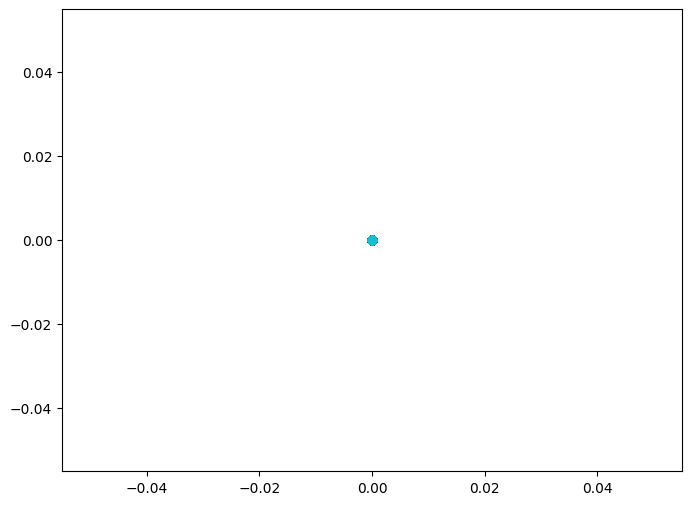

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

# Ensure the data is in the correct format
process_train_X = np.array(process_train_X).reshape(-1, 784)  # Reshape to (num_samples, 784)
process_train_Y = np.array(process_train_Y)

# Visualizing the weights and cost for all iterations
figsize(8, 6)
plt.figure()

# Plot the data points
for i in range(10):
    indices = np.argmax(process_train_Y, axis=1) == i
    plt.scatter(process_train_X[indices, 0], process_train_X[indices, 1], label=f'Label {i}', marker='o')

# Plot the decision boundary
x_min, x_max = process_train_X[:, 0].min() - 1, process_train_X[:, 0].max() + 1
y_min, y_max = process_train_X[:, 1].min() - 1, process_train_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = perceptron.forward(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [22]:
a = np.array([[0,0,1,1,1,0],[1,0,0,1,1,1]])
print(a)
b = np.array([[1,2,3,4,5,6],[6,5,4,3,2,1]])
print(b)
# Transpose b to match the shape for dot product
b_transposed = b.T
# print(b_transposed)
c = np.dot(a,b)
print(c)

[[0 0 1 1 1 0]
 [1 0 0 1 1 1]]
[[1 2 3 4 5 6]
 [6 5 4 3 2 1]]


ValueError: shapes (2,6) and (2,6) not aligned: 6 (dim 1) != 2 (dim 0)